In [3]:
# Librerias:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm
import random

In [4]:
import os
import numpy as np



base_path = ""
for dirname, _, filenames in os.walk('/kaggle/input'):
    if "train_imgs.npy" in filenames:
        base_path = dirname
        
        break

if base_path == "":
    print("❌ ERROR: No encuentro los archivos. Asegúrate de haberle dado a 'Add Input' y subirlos.")
else:
    # 2. Definir las rutas usando la base que encontramos
    train_imgs_path = os.path.join(base_path, "train_imgs.npy")
    train_annot_path = os.path.join(base_path, "train_annot.npy")

    val_imgs_path = os.path.join(base_path, "val_imgs.npy")
    val_annot_path = os.path.join(base_path, "val_annot.npy")

    test_imgs_path = os.path.join(base_path, "test_imgs.npy")
    test_annot_path = os.path.join(base_path, "test_annot.npy")

    # 3. Cargar los datos
    print("Cargando datos...")
    train_imgs = np.load(train_imgs_path)
    train_masks = np.load(train_annot_path)

    val_imgs = np.load(val_imgs_path)
    val_masks = np.load(val_annot_path)

    test_imgs = np.load(test_imgs_path)
    test_masks = np.load(test_annot_path)

    # 4. Filtrar máscaras (tu lógica original)
    train_masks = np.where(train_masks == 2, 0, train_masks)
    val_masks = np.where(val_masks == 2, 0, val_masks)
    test_masks = np.where(test_masks == 2, 0, test_masks)

    # Verificación
    print("Train images shape:", train_imgs.shape)
    print("Train masks shape:", train_masks.shape)
    print("Validation images shape:", val_imgs.shape)
    print("Validation masks shape:", val_masks.shape)
    print("Test images shape:", test_imgs.shape)
    print("Test masks shape:", test_masks.shape)

Cargando datos...
Train images shape: (4564, 256, 256)
Train masks shape: (4564, 256, 256)
Validation images shape: (502, 256, 256)
Validation masks shape: (502, 256, 256)
Test images shape: (1240, 256, 256)
Test masks shape: (1240, 256, 256)


In [ ]:
def elastic_deformation(image, mask, alpha=50, sigma=6):
    random_state = np.random.RandomState(None)

    shape = image.shape[1:]  # (H, W)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="reflect") * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)

    # cv2 remap needs channel last → convert back and forth
    img_def = cv2.remap(image[0], map_x, map_y, interpolation=cv2.INTER_LINEAR).reshape(1, *shape)
    mask_def = cv2.remap(mask[0], map_x, map_y, interpolation=cv2.INTER_NEAREST).reshape(1, *shape)

    return img_def, mask_def

# 2) Dataset con augmentación opcional

class MyocardiumDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        mask = self.masks[idx]

        image = np.expand_dims(image, 0)  # (1,H,W)
        mask = np.expand_dims(mask, 0)

        if self.augment:

            # ---- 1) Random Rotation ±10° ----
            angle = random.uniform(-10, 10)
            image = TF.rotate(torch.from_numpy(image), angle, interpolation=TF.InterpolationMode.BILINEAR).numpy()
            mask = TF.rotate(torch.from_numpy(mask), angle, interpolation=TF.InterpolationMode.NEAREST).numpy()

            # ---- 2) Random brightness/contrast (±15%) ----
            if random.random() < 0.5:
                factor = random.uniform(0.85, 1.15)
                image = image * factor
                image = np.clip(image, 0, 255)  # por si tu imagen es 0–255

            # 3) Elastic deformation suave (probabilidad 40%) 
            if random.random() < 0.4:
                image, mask = elastic_deformation(image, mask, alpha=50, sigma=6)

        # Convert to tensors
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask).float()

        return image_tensor, mask_tensor


train_dataset = MyocardiumDataset(train_imgs, train_masks, augment=True)
val_dataset   = MyocardiumDataset(val_imgs,   val_masks,   augment=False)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)


In [17]:
class ConvReluBN(nn.Module):
    """Two 3x3 convs + BN + ReLU + optional Dropout."""
    def __init__(self, in_ch, out_ch, dropout_p=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if dropout_p > 0:
            layers.append(nn.Dropout2d(p=dropout_p))
        layers += [
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if dropout_p > 0:
            layers.append(nn.Dropout2d(p=dropout_p))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class UNetPlusPlus2(nn.Module):
    def __init__(self, in_ch=1, out_ch=1,
                 filters=(64, 128, 256, 512, 1024),
                 deep_supervision=True,
                 dropout_p=[0.0, 0.1, 0.2, 0.3, 0.3]):  
        super().__init__()
        self.deep_supervision = deep_supervision
        self.filters = list(filters)
        self.dropout_p = dropout_p
        assert len(self.filters) == 5

        # Encoder (X_{i,0})
        self.conv0_0 = ConvReluBN(in_ch,   self.filters[0], dropout_p=self.dropout_p[0])
        self.conv1_0 = ConvReluBN(self.filters[0], self.filters[1], dropout_p=self.dropout_p[1])
        self.conv2_0 = ConvReluBN(self.filters[1], self.filters[2], dropout_p=self.dropout_p[2])
        self.conv3_0 = ConvReluBN(self.filters[2], self.filters[3], dropout_p=self.dropout_p[3])
        self.conv4_0 = ConvReluBN(self.filters[3], self.filters[4], dropout_p=self.dropout_p[4])
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Nested decoder blocks X_{i,j}, j>=1
        # Build them programmatically and register in ModuleDict
        blocks = {}
        for i in range(0, 4):
            for j in range(1, 5 - i):
                in_chs = self._calc_in_channels(i, j)
                blocks[f"conv{i}_{j}"] = ConvReluBN(in_chs, self.filters[i], dropout_p=self.dropout_p[i])
        self.blocks = nn.ModuleDict(blocks)

        # Deep supervision heads at X_{0,1..4}
        self.heads = nn.ModuleList([
            nn.Conv2d(self.filters[0], out_ch, kernel_size=1) for _ in range(4)
        ])

    # ---- helper to compute input channels for conv{i}_{j} ----
    # X_{i,j} takes concat([X_{i,0..j-1], Up(X_{i+1,j-1])])
    def _calc_in_channels(self, i, j):
        ch = j * self.filters[i]  # X_{i,0..j-1} -> j tensors of filters[i] each
        ch += self.filters[i + 1]  # Up(X_{i+1,j-1}) has channels filters[i+1]
        return ch

    # ---- forward ----
    def forward(self, x):
        # Encoder path (column j=0)
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Store all nodes in a grid-like structure: nodes[i][j] -> X_{i,j}
        nodes = [[None]* (5 - i) for i in range(5)]
        nodes[0][0], nodes[1][0], nodes[2][0], nodes[3][0], nodes[4][0] = x0_0, x1_0, x2_0, x3_0, x4_0

        # Fill the grid column by column (j from 1 to 4)
        for j in range(1, 5):  # j = 1..4
            for i in range(0, 5 - j):  # i = 0..(4-j)
                # inputs: X_{i,0..j-1} and Up(X_{i+1,j-1})
                concat_list = [nodes[i][k] for k in range(j)]
                up_in = self.up(nodes[i + 1][j - 1])
                concat_list.append(up_in)
                inp = torch.cat(concat_list, dim=1)
                nodes[i][j] = self.blocks[f"conv{i}_{j}"](inp)

        # Deep supervision outputs at X_{0,1}, X_{0,2}, X_{0,3}, X_{0,4}
        out1 = self.heads[0](nodes[0][1])
        out2 = self.heads[1](nodes[0][2])
        out3 = self.heads[2](nodes[0][3])
        out4 = self.heads[3](nodes[0][4])
        return [out1, out2, out3, out4]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
  
    def __init__(self, alpha, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits : raw model outputs (no sigmoid)
        # targets: {0,1}

        targets = targets.float()
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        
        # pt = exp(-BCE)
        pt = torch.exp(-bce_loss)
        alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        focal_loss = alpha_t * ((1 - pt) ** self.gamma) * bce_loss


        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [21]:
# 4. Set up and run the training loop (MONAI FocalLoss)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim


# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNetPlusPlus2(
    in_ch=1,
    out_ch=1,
    filters=(64, 128, 256, 512, 1024),
    deep_supervision=True,
    dropout_p=[0.0, 0.1, 0.2, 0.3, 0.3]
).to(device)

criterion = BinaryFocalLoss(alpha=0.85, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)

# --- Métrica IoU ---
def calculate_iou(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# --- Historial ---
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

NUM_EPOCHS = 60
best_val_iou = -1.0
print("Starting training...")

for epoch in range(NUM_EPOCHS):

    # --- Training Phase ---
    model.train()
    train_loss, train_iou = 0.0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)  # list of 4 outputs

        # Deep supervision: weighted sum of losses
        loss1 = criterion(outputs[0], masks)
        loss2 = criterion(outputs[1], masks)
        loss3 = criterion(outputs[2], masks)
        loss4 = criterion(outputs[3], masks)
        loss = 0.05*loss1 + 0.1*loss2 + 0.25*loss3 + 0.60*loss4

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # IoU solo con la salida final (outputs[-1])
        pred_final = outputs[-1]
        train_iou += calculate_iou(pred_final, masks).item()

        pbar.set_postfix({'Train Loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['train_iou'].append(avg_train_iou)

    # --- Validation Phase ---
    model.eval()
    val_loss, val_iou = 0.0, 0.0
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for images, masks in pbar_val:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Usamos solo la salida final (profunda)
            pred_final = outputs[-1] if isinstance(outputs, list) else outputs
            vloss = criterion(pred_final, masks)
            val_loss += vloss.item()

            val_iou += calculate_iou(pred_final, masks).item()
            pbar_val.set_postfix({'Val Loss': vloss.item()})

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_iou'].append(avg_val_iou)

    # --- Ajuste LR scheduler ---
    scheduler.step(avg_val_iou)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1:02d} | Train Loss {avg_train_loss:.4f} | Train IoU {avg_train_iou:.4f} | "
          f"Val Loss {avg_val_loss:.4f} | Val IoU {avg_val_iou:.4f} | LR {current_lr:.1e}")

    # --- Guardar mejor modelo ---
    if avg_val_iou > best_val_iou:
        best_val_iou = avg_val_iou
        torch.save(model.state_dict(), 'best_unetpp_focal.pth')
        print(f"✅ New best model saved with IoU: {best_val_iou:.4f}")

print("Training finished.")


Using device: cuda
Starting training...


Epoch 1/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00761]


Epoch 01 | Train Loss 0.0220 | Train IoU 0.2682 | Val Loss 0.0084 | Val IoU 0.4216 | LR 1.0e-04
✅ New best model saved with IoU: 0.4216


Epoch 2/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00403]


Epoch 02 | Train Loss 0.0065 | Train IoU 0.6533 | Val Loss 0.0043 | Val IoU 0.6231 | LR 1.0e-04
✅ New best model saved with IoU: 0.6231


Epoch 3/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00353]


Epoch 03 | Train Loss 0.0038 | Train IoU 0.7380 | Val Loss 0.0035 | Val IoU 0.6438 | LR 1.0e-04
✅ New best model saved with IoU: 0.6438


Epoch 4/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.0035] 


Epoch 04 | Train Loss 0.0029 | Train IoU 0.7590 | Val Loss 0.0030 | Val IoU 0.6528 | LR 1.0e-04
✅ New best model saved with IoU: 0.6528


Epoch 5/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00243]


Epoch 05 | Train Loss 0.0024 | Train IoU 0.7734 | Val Loss 0.0024 | Val IoU 0.7092 | LR 1.0e-04
✅ New best model saved with IoU: 0.7092


Epoch 6/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00225] 


Epoch 06 | Train Loss 0.0021 | Train IoU 0.7846 | Val Loss 0.0025 | Val IoU 0.6626 | LR 1.0e-04


Epoch 7/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00214] 


Epoch 07 | Train Loss 0.0020 | Train IoU 0.7876 | Val Loss 0.0025 | Val IoU 0.6857 | LR 1.0e-04


Epoch 8/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00169] 


Epoch 08 | Train Loss 0.0019 | Train IoU 0.7958 | Val Loss 0.0019 | Val IoU 0.7457 | LR 1.0e-04
✅ New best model saved with IoU: 0.7457


Epoch 9/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00215] 


Epoch 09 | Train Loss 0.0018 | Train IoU 0.7983 | Val Loss 0.0024 | Val IoU 0.7137 | LR 1.0e-04


Epoch 10/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.0019]  


Epoch 10 | Train Loss 0.0017 | Train IoU 0.8062 | Val Loss 0.0023 | Val IoU 0.7154 | LR 1.0e-04


Epoch 11/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00193] 


Epoch 11 | Train Loss 0.0018 | Train IoU 0.7959 | Val Loss 0.0023 | Val IoU 0.7193 | LR 1.0e-04


Epoch 12/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00195] 


Epoch 12 | Train Loss 0.0016 | Train IoU 0.8106 | Val Loss 0.0021 | Val IoU 0.7338 | LR 1.0e-04


Epoch 13/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00149] 


Epoch 13 | Train Loss 0.0016 | Train IoU 0.8099 | Val Loss 0.0023 | Val IoU 0.7112 | LR 5.0e-05


Epoch 14/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00141] 


Epoch 14 | Train Loss 0.0014 | Train IoU 0.8254 | Val Loss 0.0021 | Val IoU 0.7432 | LR 5.0e-05


Epoch 15/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00154] 


Epoch 15 | Train Loss 0.0014 | Train IoU 0.8301 | Val Loss 0.0020 | Val IoU 0.7468 | LR 5.0e-05
✅ New best model saved with IoU: 0.7468


Epoch 16/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.84it/s, Val Loss=0.00155] 


Epoch 16 | Train Loss 0.0014 | Train IoU 0.8292 | Val Loss 0.0022 | Val IoU 0.7260 | LR 5.0e-05


Epoch 17/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00129] 


Epoch 17 | Train Loss 0.0013 | Train IoU 0.8312 | Val Loss 0.0020 | Val IoU 0.7386 | LR 5.0e-05


Epoch 18/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00148] 


Epoch 18 | Train Loss 0.0014 | Train IoU 0.8291 | Val Loss 0.0022 | Val IoU 0.7333 | LR 5.0e-05


Epoch 19/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00112] 


Epoch 19 | Train Loss 0.0013 | Train IoU 0.8364 | Val Loss 0.0020 | Val IoU 0.7575 | LR 5.0e-05
✅ New best model saved with IoU: 0.7575


Epoch 20/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00244] 


Epoch 20 | Train Loss 0.0013 | Train IoU 0.8374 | Val Loss 0.0022 | Val IoU 0.7479 | LR 5.0e-05


Epoch 21/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.0015]  


Epoch 21 | Train Loss 0.0014 | Train IoU 0.8300 | Val Loss 0.0019 | Val IoU 0.7539 | LR 5.0e-05


Epoch 22/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00121] 


Epoch 22 | Train Loss 0.0013 | Train IoU 0.8400 | Val Loss 0.0022 | Val IoU 0.7413 | LR 5.0e-05


Epoch 23/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00127] 


Epoch 23 | Train Loss 0.0012 | Train IoU 0.8416 | Val Loss 0.0019 | Val IoU 0.7650 | LR 5.0e-05
✅ New best model saved with IoU: 0.7650


Epoch 24/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00225] 


Epoch 24 | Train Loss 0.0012 | Train IoU 0.8413 | Val Loss 0.0027 | Val IoU 0.6839 | LR 5.0e-05


Epoch 25/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00147] 


Epoch 25 | Train Loss 0.0013 | Train IoU 0.8364 | Val Loss 0.0023 | Val IoU 0.7352 | LR 5.0e-05


Epoch 26/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00164] 


Epoch 26 | Train Loss 0.0012 | Train IoU 0.8440 | Val Loss 0.0020 | Val IoU 0.7449 | LR 5.0e-05


Epoch 27/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00209] 


Epoch 27 | Train Loss 0.0012 | Train IoU 0.8441 | Val Loss 0.0023 | Val IoU 0.7306 | LR 5.0e-05


Epoch 28/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00126] 


Epoch 28 | Train Loss 0.0012 | Train IoU 0.8440 | Val Loss 0.0023 | Val IoU 0.7258 | LR 2.5e-05


Epoch 29/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.0012]  


Epoch 29 | Train Loss 0.0011 | Train IoU 0.8527 | Val Loss 0.0020 | Val IoU 0.7560 | LR 2.5e-05


Epoch 30/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00154] 


Epoch 30 | Train Loss 0.0011 | Train IoU 0.8557 | Val Loss 0.0022 | Val IoU 0.7471 | LR 2.5e-05


Epoch 31/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.0012]  


Epoch 31 | Train Loss 0.0011 | Train IoU 0.8568 | Val Loss 0.0020 | Val IoU 0.7609 | LR 2.5e-05


Epoch 32/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00133] 


Epoch 32 | Train Loss 0.0011 | Train IoU 0.8559 | Val Loss 0.0023 | Val IoU 0.7295 | LR 2.5e-05


Epoch 33/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.0012]  


Epoch 33 | Train Loss 0.0011 | Train IoU 0.8583 | Val Loss 0.0020 | Val IoU 0.7609 | LR 1.3e-05


Epoch 34/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00117] 


Epoch 34 | Train Loss 0.0010 | Train IoU 0.8634 | Val Loss 0.0020 | Val IoU 0.7710 | LR 1.3e-05
✅ New best model saved with IoU: 0.7710


Epoch 35/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00106] 


Epoch 35 | Train Loss 0.0010 | Train IoU 0.8637 | Val Loss 0.0020 | Val IoU 0.7703 | LR 1.3e-05


Epoch 36/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00134] 


Epoch 36 | Train Loss 0.0010 | Train IoU 0.8650 | Val Loss 0.0020 | Val IoU 0.7734 | LR 1.3e-05
✅ New best model saved with IoU: 0.7734


Epoch 37/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00112] 


Epoch 37 | Train Loss 0.0010 | Train IoU 0.8657 | Val Loss 0.0020 | Val IoU 0.7678 | LR 1.3e-05


Epoch 38/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00144] 


Epoch 38 | Train Loss 0.0010 | Train IoU 0.8666 | Val Loss 0.0019 | Val IoU 0.7763 | LR 1.3e-05
✅ New best model saved with IoU: 0.7763


Epoch 39/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00123] 


Epoch 39 | Train Loss 0.0010 | Train IoU 0.8669 | Val Loss 0.0020 | Val IoU 0.7704 | LR 1.3e-05


Epoch 40/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00109] 


Epoch 40 | Train Loss 0.0010 | Train IoU 0.8671 | Val Loss 0.0022 | Val IoU 0.7591 | LR 1.3e-05


Epoch 41/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00106] 


Epoch 41 | Train Loss 0.0010 | Train IoU 0.8684 | Val Loss 0.0020 | Val IoU 0.7719 | LR 1.3e-05


Epoch 42/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00125] 


Epoch 42 | Train Loss 0.0010 | Train IoU 0.8687 | Val Loss 0.0023 | Val IoU 0.7567 | LR 1.3e-05


Epoch 43/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00114] 


Epoch 43 | Train Loss 0.0010 | Train IoU 0.8690 | Val Loss 0.0020 | Val IoU 0.7683 | LR 6.3e-06


Epoch 44/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00105] 


Epoch 44 | Train Loss 0.0010 | Train IoU 0.8722 | Val Loss 0.0021 | Val IoU 0.7719 | LR 6.3e-06


Epoch 45/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00102] 


Epoch 45 | Train Loss 0.0010 | Train IoU 0.8728 | Val Loss 0.0021 | Val IoU 0.7658 | LR 6.3e-06


Epoch 46/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.0011]  


Epoch 46 | Train Loss 0.0010 | Train IoU 0.8734 | Val Loss 0.0022 | Val IoU 0.7647 | LR 6.3e-06


Epoch 47/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.00106] 


Epoch 47 | Train Loss 0.0010 | Train IoU 0.8738 | Val Loss 0.0021 | Val IoU 0.7686 | LR 6.3e-06


Epoch 48/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.000947]


Epoch 48 | Train Loss 0.0010 | Train IoU 0.8744 | Val Loss 0.0021 | Val IoU 0.7714 | LR 3.1e-06


Epoch 49/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s, Val Loss=0.001]   


Epoch 49 | Train Loss 0.0009 | Train IoU 0.8757 | Val Loss 0.0021 | Val IoU 0.7687 | LR 3.1e-06


Epoch 50/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.000959]


Epoch 50 | Train Loss 0.0009 | Train IoU 0.8763 | Val Loss 0.0022 | Val IoU 0.7654 | LR 3.1e-06


Epoch 51/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00102] 


Epoch 51 | Train Loss 0.0009 | Train IoU 0.8769 | Val Loss 0.0022 | Val IoU 0.7690 | LR 3.1e-06


Epoch 52/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00109] 


Epoch 52 | Train Loss 0.0009 | Train IoU 0.8763 | Val Loss 0.0021 | Val IoU 0.7748 | LR 3.1e-06


Epoch 53/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00106] 


Epoch 53 | Train Loss 0.0009 | Train IoU 0.8770 | Val Loss 0.0021 | Val IoU 0.7734 | LR 1.6e-06


Epoch 54/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00105] 


Epoch 54 | Train Loss 0.0009 | Train IoU 0.8776 | Val Loss 0.0021 | Val IoU 0.7728 | LR 1.6e-06


Epoch 55/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00102] 


Epoch 55 | Train Loss 0.0009 | Train IoU 0.8784 | Val Loss 0.0022 | Val IoU 0.7721 | LR 1.6e-06


Epoch 56/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00108] 


Epoch 56 | Train Loss 0.0009 | Train IoU 0.8781 | Val Loss 0.0021 | Val IoU 0.7766 | LR 1.6e-06
✅ New best model saved with IoU: 0.7766


Epoch 57/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00102] 


Epoch 57 | Train Loss 0.0009 | Train IoU 0.8786 | Val Loss 0.0021 | Val IoU 0.7739 | LR 1.6e-06


Epoch 58/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00107] 


Epoch 58 | Train Loss 0.0009 | Train IoU 0.8789 | Val Loss 0.0022 | Val IoU 0.7736 | LR 1.6e-06


Epoch 59/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00105] 


Epoch 59 | Train Loss 0.0009 | Train IoU 0.8787 | Val Loss 0.0022 | Val IoU 0.7725 | LR 1.6e-06


Epoch 60/60 [Val]: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s, Val Loss=0.00107] 

Epoch 60 | Train Loss 0.0009 | Train IoU 0.8786 | Val Loss 0.0021 | Val IoU 0.7731 | LR 1.6e-06
Training finished.


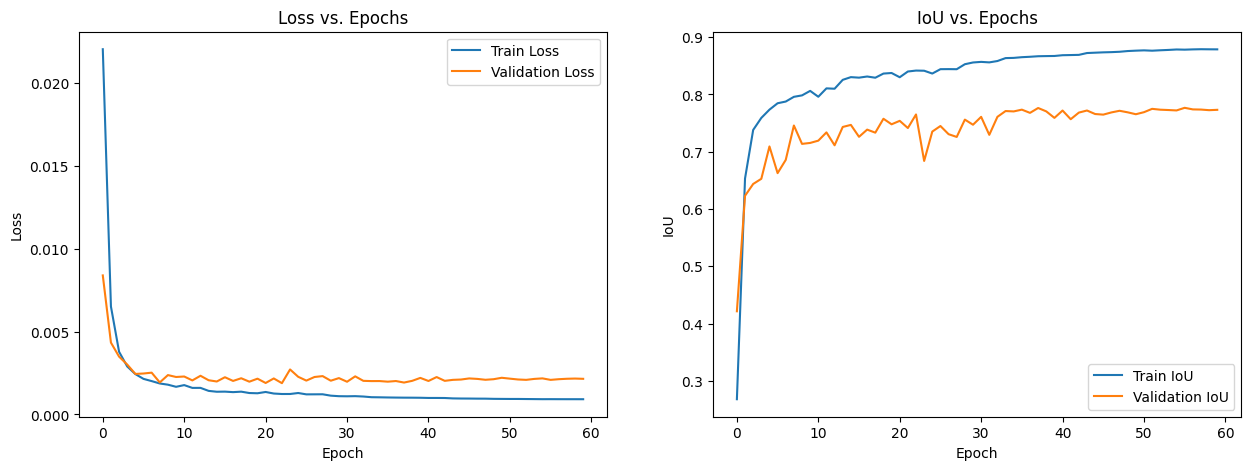

In [23]:
# 5. Graphing Training & Validation Metrics

def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    
    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title("Loss vs. Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot IoU
    ax2.plot(history['train_iou'], label='Train IoU')
    ax2.plot(history['val_iou'], label='Validation IoU')
    ax2.set_title("IoU vs. Epochs")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("IoU")
    ax2.legend()

    plt.show()

# Call the function
plot_metrics(history)

Running evaluation on test set...


Testing: 100%|██████████| 155/155 [00:32<00:00,  4.79it/s]



--- Average Test IoU: 0.7335 ---


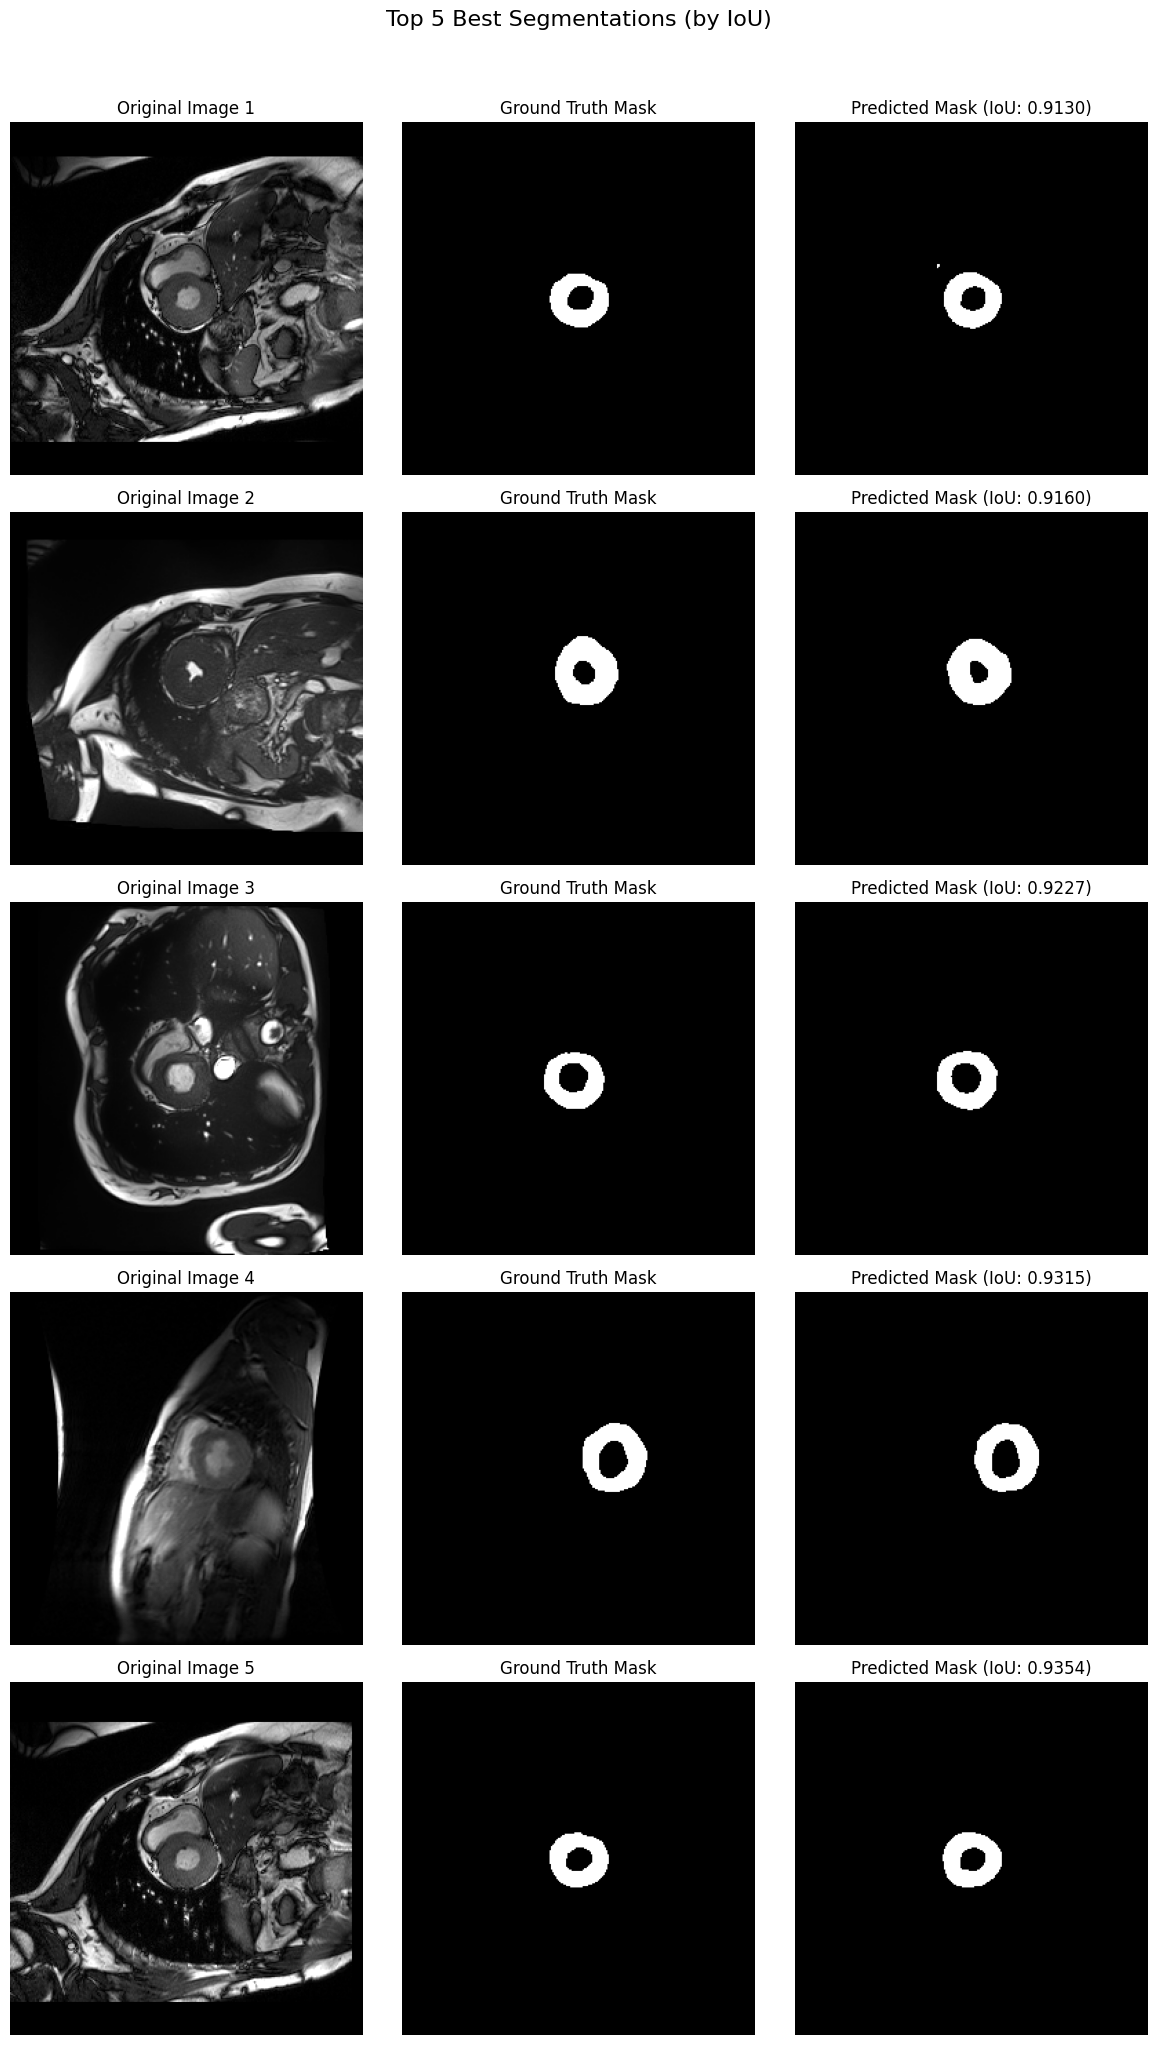

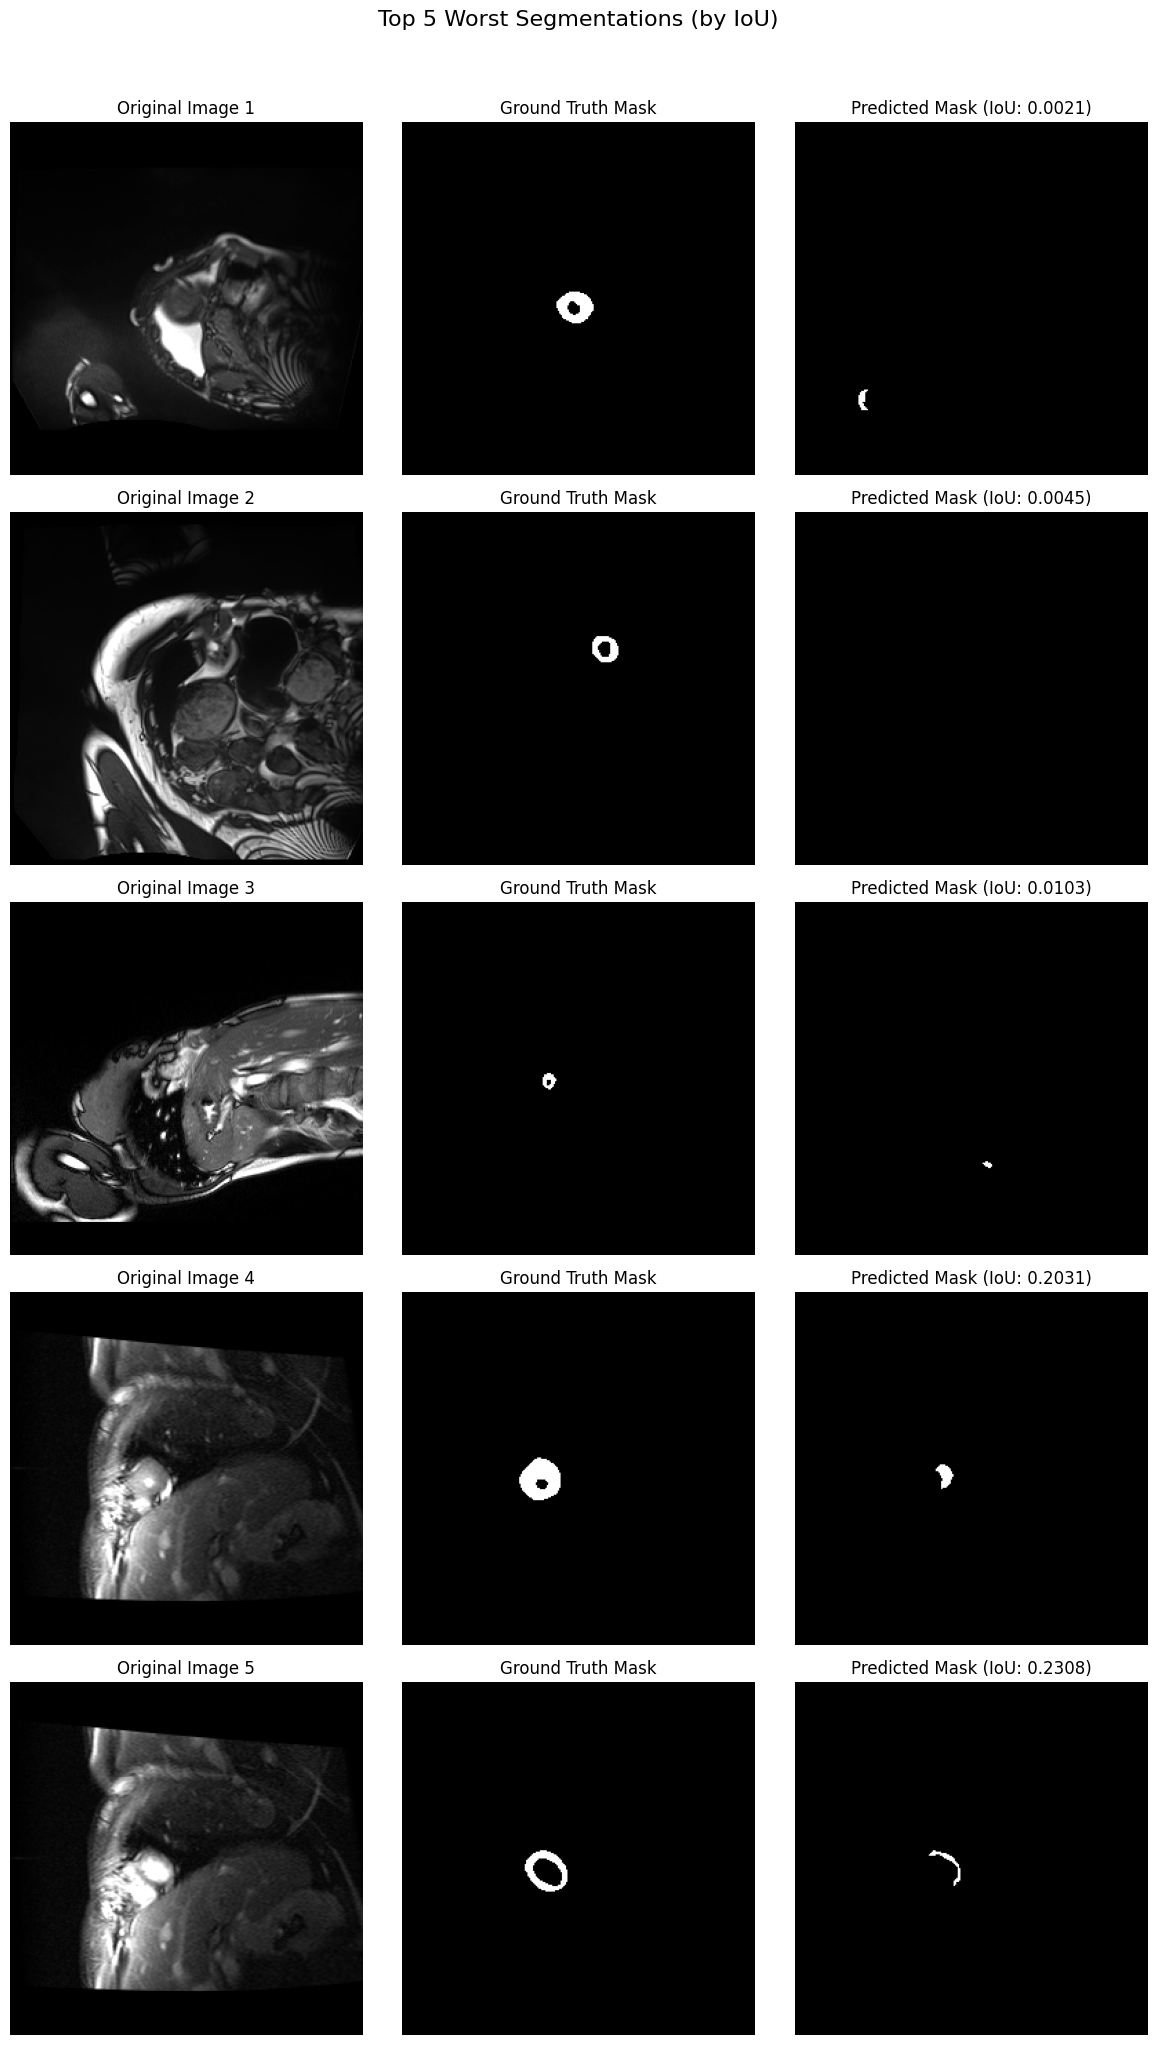

In [25]:

# 6. Test Set Evaluation

# --- Helper function to plot samples ---
def plot_samples(images, gt_masks, pred_masks, iou_scores, title):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images) * 4))
    fig.suptitle(title, fontsize=16, y=1.02)

    for i in range(len(images)):
        # Detach tensors, move to CPU, convert to NumPy, and adjust dimensions
        img = images[i].cpu().numpy().squeeze()
        gt = gt_masks[i].cpu().numpy().squeeze()
        pred = pred_masks[i].cpu().numpy().squeeze()

        # Apply sigmoid and threshold to prediction
        pred = 1 / (1 + np.exp(-pred)) # Sigmoid
        pred = (pred > 0.5).astype(float) # Threshold

        # Original Image
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(gt, cmap='gray')
        axes[i, 1].set_title(f"Ground Truth Mask")
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask (IoU: {iou_scores[i]:.4f})")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# --- Create Test Dataset and DataLoader ---
test_dataset = MyocardiumDataset(test_imgs, test_masks)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Load the best model ---
model = UNetPlusPlus2(
    in_ch=1,
    out_ch=1,
    filters=(64, 128, 256, 512, 1024),
    deep_supervision=True,
    dropout_p=[0.0, 0.1, 0.2, 0.3, 0.3]  # aplica dropout progresivo
).to(device)


model.load_state_dict(torch.load('best_unetpp_focal_tversky.pth', map_location=device))
model.eval()

# --- Store all test results ---
all_test_ious = []
all_images = []
all_gt_masks = []
all_pred_masks = []

print("Running evaluation on test set...")
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device)

        # Get 4 outputs and average them
        outputs = model(images)
        output_avg = (outputs[0] + outputs[1] + outputs[2] + outputs[3])/4

        # Calculate IoU for each item in the batch
        for i in range(images.shape[0]):
            img = images[i]
            gt = masks[i]
            pred = output_avg[i]

            iou = calculate_iou(pred, gt).item()

            all_test_ious.append(iou)
            all_images.append(img)
            all_gt_masks.append(gt)
            all_pred_masks.append(pred) # Store the logit output

# --- Calculate Average IoU ---
avg_test_iou = np.mean(all_test_ious)
print(f"\n--- Average Test IoU: {avg_test_iou:.4f} ---")

# --- Find Best and Worst Samples ---
sorted_indices = np.argsort(all_test_ious)

# Get best 5
best_indices = sorted_indices[-5:]
best_images = [all_images[i] for i in best_indices]
best_gts = [all_gt_masks[i] for i in best_indices]
best_preds = [all_pred_masks[i] for i in best_indices]
best_ious = [all_test_ious[i] for i in best_indices]

# Get worst 5
worst_indices = sorted_indices[:5]
worst_images = [all_images[i] for i in worst_indices]
worst_gts = [all_gt_masks[i] for i in worst_indices]
worst_preds = [all_pred_masks[i] for i in worst_indices]
worst_ious = [all_test_ious[i] for i in worst_indices]

# --- Plot the results ---
plot_samples(best_images, best_gts, best_preds, best_ious, "Top 5 Best Segmentations (by IoU)")
plot_samples(worst_images, worst_gts, worst_preds, worst_ious, "Top 5 Worst Segmentations (by IoU)")